In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
data_pr = Project("import_database")

In [4]:
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,21,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,GenericJob,0.4,None,None
1,22,finished,None,df3_10k,/df3_10k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,GenericJob,0.4,None,None
2,23,finished,None,df2_1k,/df2_1k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,GenericJob,0.4,None,None


In [5]:
data_job = data_pr.load('df1_A1_A2_A3_EV_elast_phon')

# Fitting project

In [8]:
from pyiron_gpl.pacemaker.pacemaker import PaceMakerJob

In [9]:
fit_pr = Project("pacemaker_fit")

In [10]:
#fit_pr.remove_jobs_silently()#

In [11]:
job = fit_pr.create_job(job_type=PaceMakerJob, job_name="df1_cut5") #,delete_existing_job=True

## Fit

In [14]:
cutoff = 5.0

In [15]:
job.input["potential"]= {
    "deltaSplineBins": 0.001,
    "element": "Cu",
    "fs_parameters": [1, 1, 1, 0.5],
    "npot": "FinnisSinclairShiftedScaled",
    "NameOfCutoffFunction": "cos",
    "rankmax": 3,
    "nradmax": [5,2,1],
    "lmax": [0,2,1],
    "ndensity": 2,
    "rcut": cutoff,
    "dcut": 0.01,
    "radparameters": [5.25],
    "radbase": "ChebExpCos",
}

In [16]:
job.input["fit"]= {    
    'optimizer': 'BFGS', 
    'maxiter': 500,
    'loss': {
        'kappa': 0.5,
        'L1_coeffs': 5e-7, # L1-regularization
        'L2_coeffs': 5e-7, # L2-regularization
        'w1_coeffs': 1,
        'w2_coeffs': 1,
        #radial smoothness regularization
        'w0_rad': 1e-4,    
        'w1_rad': 1e-4,
        'w2_rad': 1e-4,
    },
}

In [17]:
job.input["cutoff"] = cutoff
job.input["backend"]["batch_size"] = 1000 # large batch size, because fitting will be done on CPU

In [18]:
job.structure_data=data_job

In [19]:
job.input

,Parameter,Value,Comment
0,cutoff,5.0,
1,metadata,{},
2,data,{},
3,potential,"{'deltaSplineBins': 0.001, 'element': 'Cu', 'fs_parameters': [1, 1, 1, 0.5], 'npot': 'FinnisSinclairShiftedScaled', 'NameOfCutoffFunction': 'cos', 'rankmax': 3, 'nradmax': [5, 2, 1], 'lmax': [0, 2...",
4,fit,"{'optimizer': 'BFGS', 'maxiter': 500, 'loss': {'kappa': 0.5, 'L1_coeffs': 5e-07, 'L2_coeffs': 5e-07, 'w1_coeffs': 1, 'w2_coeffs': 1, 'w0_rad': 0.0001, 'w1_rad': 0.0001, 'w2_rad': 0.0001}}",
5,backend,"{'evaluator': 'tensorpot', 'batch_size': 1000}",


In [20]:
job.executable.available_versions

['tf', 'tf_cpu']

In [21]:
job.executable.version="tf_cpu" # select the CPU-forces tensorflow version

In [22]:
job.run()

2021-02-26 18:00:20,020 - root - INFO - structure_data is TrainingContainer
2021-02-26 18:00:20,032 - root - INFO - Saving training structures dataframe into /home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_hdf5/df1_cut5/df_fit.pckl.gzip with pickle protocol = 4, compression = gzip


The job df1_cut5 was saved and received the ID: 62


In [23]:
fit_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,62,finished,None,df1_cut5,/df1_cut5,/home/yury/pyiron/projects/,pyiron-2021/pacemaker_fit/,2021-02-26 18:00:20.326459,2021-02-26 18:02:25.068815,124.0,pyiron@dell-inspiron#1,PaceMakerJob,0.1,None,None


Text(0, 0.5, 'Loss')

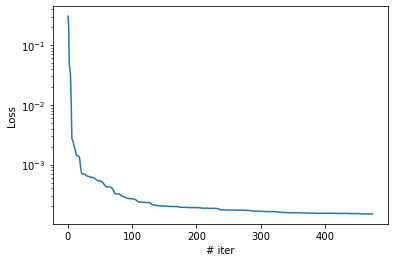

In [24]:
plt.plot(job["output/log/loss"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Loss")

Text(0, 0.5, 'Energy RMSE, meV/atom')

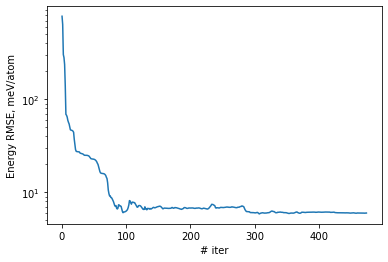

In [25]:
plt.plot(job["output/log/rmse_energy"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Energy RMSE, meV/atom")

Text(0, 0.5, 'Forces RMSE, meV/Ang/structure')

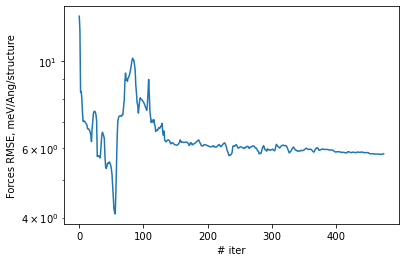

In [26]:
plt.plot(job["output/log/rmse_forces"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Forces RMSE, meV/Ang/structure")

# Overview of the fitted potential internals

In [27]:
from pyace import *

In [28]:
final_potential = job.get_final_potential()

Total number of basis functions

In [72]:
final_potential.total_number_of_functions

16

Total number of fittable parameter:

In [77]:
all_potential_params = final_potential.get_all_coeffs()
len(all_potential_params)

62

List of B-basis functions and corresponding fitted coefficients:

In [29]:
Cu_block = final_potential.funcspecs_blocks[0]

In [81]:
np.shape(Cu_block.radcoefficients)

(2, 3, 5)

In [30]:
Cu_block.funcspecs

[BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[1],  ls=[0],  coeffs=[-1.45508,0.386965]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[2],  ls=[0],  coeffs=[0.187659,0.0311263]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[3],  ls=[0],  coeffs=[0.61501,0.166795]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[4],  ls=[0],  coeffs=[0.610658,0.127375]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[5],  ls=[0],  coeffs=[0.012375,-0.0574038]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[0,0],  coeffs=[0.105674,-0.249878]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[1,1],  coeffs=[0.335125,0.098442]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[2,2],  coeffs=[0.372051,0.0553928]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,1],  ls=[0,0],  coeffs=[1.90605,0.934764]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,1],  ls=[1,1],  coeffs=[0.00318017,0.000454939]),
 BBasis

There are following B-functions:
* 5 functions of 1st order (pair correlations)
```
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[1],  ls=[0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[2],  ls=[0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[3],  ls=[0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[4],  ls=[0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[5],  ls=[0],  coeffs=)
```
* 9 functions of 2nd order (three-body clusters)
```
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[0,0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[1,1],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[2,2],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,1],  ls=[0,0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,1],  ls=[1,1],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,1],  ls=[2,2],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,2],  ls=[0,0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,2],  ls=[1,1],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[2,2],  ls=[2,2],  coeffs=)
 ```
* 2 functions of 3rd order (four-body clusters)
```
BBasisFunctionSpecification(elements=[Cu,Cu,Cu,Cu],  ns=[1,1,1],  ls=[0,0,0],  LS=[0],  coeffs=),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu,Cu],  ns=[1,1,1],  ls=[1,1,0],  LS=[0],  coeffs=)]
```

In [31]:
final_basis_set = ACEBBasisSet(final_potential)

In [32]:
rad_func_vals = RadialFunctionsValues(final_basis_set)

Visualize the radial basis functions ($g_k$) and radial functions ($R_{nl}$)

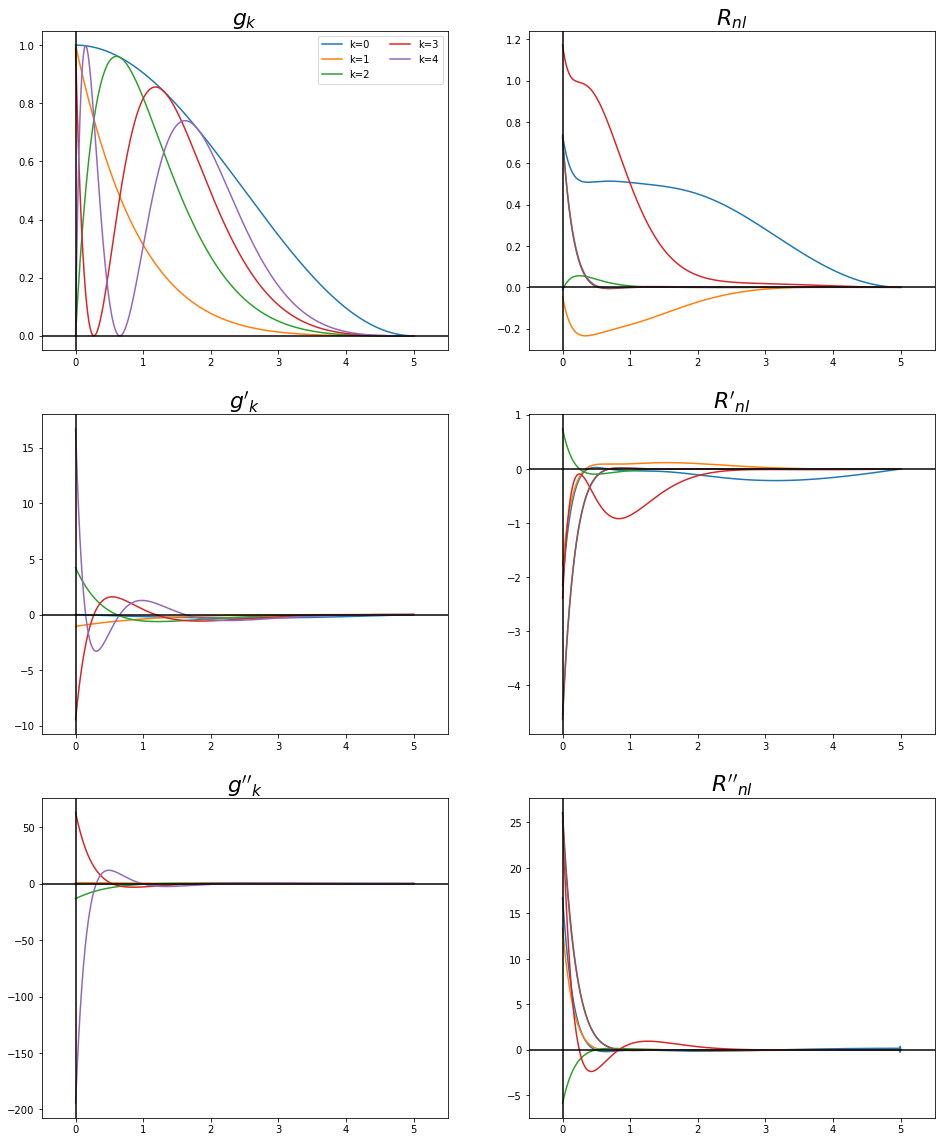

In [33]:
RadialFunctionsVisualization(final_basis_set).plot()

# Test fitted potential

In [34]:
test_pr = Project("test_ace_potential")

In [35]:
test_pr.remove_jobs_silently()

In [36]:
test_pr.job_table()

""


In [37]:
cu_ace_potential = job.get_lammps_potential()

In [38]:
cu_ace_potential


,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_hdf5/df1_cut5/df1_cut5.ace Cu\n]",,ACE,df1_cut5,[Cu]


## Optimization

In [39]:
lammps_job = test_pr.create.job.Lammps("opt_lammps", delete_existing_job=True)

In [40]:
lammps_job.executable.version="2020.12.24_pace"

In [41]:
lammps_job.potential = cu_ace_potential

In [42]:
lammps_job.structure = test_pr.create.structure.ase_bulk("Cu","fcc",cubic=True)

In [43]:
lammps_job.calc_minimize(pressure=0.0)

In [44]:
lammps_job.run()

The job opt_lammps was saved and received the ID: 63


In [45]:
test_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,63,finished,Cu4,opt_lammps,/opt_lammps,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 18:04:32.780177,2021-02-26 18:04:33.357484,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,None


## Elastic matrix

In [46]:
elmat_job = test_pr.create.job.ElasticMatrixJob("elmat", delete_existing_job=True)

In [47]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [48]:
ref_job.executable.version="2020.12.24_pace"

In [49]:
ref_job.potential = cu_ace_potential

In [50]:
ref_job.structure = lammps_job.get_structure()

In [51]:
ref_job.server.run_mode="non_modal"

In [52]:
elmat_job.ref_job = ref_job

In [ ]:
elmat_job.run(run_mode="non_modal")

In [59]:
test_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,63,finished,Cu4,opt_lammps,/opt_lammps,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 18:04:32.780177,2021-02-26 18:04:33.357484,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,NaN
1,64,finished,Cu4,elmat,/elmat,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 18:04:39.479256,2021-02-26 18:06:14.116217,94.0,pyiron@dell-inspiron#1#1/13,ElasticMatrixJob,0.0.1,None,NaN
2,65,finished,Cu4,s_e_0,/s_e_0,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:43.347077,2021-02-26 18:04:43.979010,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
3,66,finished,Cu4,s_01_e_m0_00500,/s_01_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:48.669551,2021-02-26 18:04:49.371648,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
4,67,finished,Cu4,s_01_e_m0_00250,/s_01_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:54.692191,2021-02-26 18:04:55.399713,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
5,68,finished,Cu4,s_01_e_0_00250,/s_01_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:01.081338,2021-02-26 18:05:01.705611,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
6,69,finished,Cu4,s_01_e_0_00500,/s_01_e_0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:08.559196,2021-02-26 18:05:09.262691,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
7,70,finished,Cu4,s_08_e_m0_00500,/s_08_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:15.329561,2021-02-26 18:05:15.968879,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
8,71,finished,Cu4,s_08_e_m0_00250,/s_08_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:22.381961,2021-02-26 18:05:23.034119,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
9,72,finished,Cu4,s_08_e_0_00250,/s_08_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:29.893494,2021-02-26 18:05:30.536530,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0


In [60]:
elmat_job["output/elasticmatrix"]["C"]

array([[188.94040052, 146.00702034, 146.00702034,   0.        ,
          0.        ,   0.        ],
       [146.00702034, 188.94040052, 146.00702034,   0.        ,
          0.        ,   0.        ],
       [146.00702034, 146.00702034, 188.94040052,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  92.42800604,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         92.42800604,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  92.42800604]])

## Phonons

In [61]:
phon_job = test_pr.create.job.PhonopyJob("phon_job", delete_existing_job=True)

In [62]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [63]:
ref_job.executable.version="2020.12.24_pace"

In [64]:
ref_job.potential = cu_ace_potential

In [65]:
ref_job.structure = lammps_job.get_structure()

In [66]:
phon_job.input['dos_mesh']=75

In [67]:
phon_job.ref_job = ref_job

In [68]:
phon_job.run()

The job phon_job was saved and received the ID: 78
The job ref_job_0 was saved and received the ID: 79


In [69]:
test_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,63,finished,Cu4,opt_lammps,/opt_lammps,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 18:04:32.780177,2021-02-26 18:04:33.357484,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,NaN
1,64,finished,Cu4,elmat,/elmat,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 18:04:39.479256,2021-02-26 18:06:14.116217,94.0,pyiron@dell-inspiron#1#1/13,ElasticMatrixJob,0.0.1,None,NaN
2,65,finished,Cu4,s_e_0,/s_e_0,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:43.347077,2021-02-26 18:04:43.979010,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
3,66,finished,Cu4,s_01_e_m0_00500,/s_01_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:48.669551,2021-02-26 18:04:49.371648,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
4,67,finished,Cu4,s_01_e_m0_00250,/s_01_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:04:54.692191,2021-02-26 18:04:55.399713,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
5,68,finished,Cu4,s_01_e_0_00250,/s_01_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:01.081338,2021-02-26 18:05:01.705611,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
6,69,finished,Cu4,s_01_e_0_00500,/s_01_e_0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:08.559196,2021-02-26 18:05:09.262691,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
7,70,finished,Cu4,s_08_e_m0_00500,/s_08_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:15.329561,2021-02-26 18:05:15.968879,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
8,71,finished,Cu4,s_08_e_m0_00250,/s_08_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:22.381961,2021-02-26 18:05:23.034119,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
9,72,finished,Cu4,s_08_e_0_00250,/s_08_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 18:05:29.893494,2021-02-26 18:05:30.536530,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0


<AxesSubplot:title={'center':'Phonon DOS vs Energy'}, xlabel='Frequency [THz]', ylabel='DOS'>

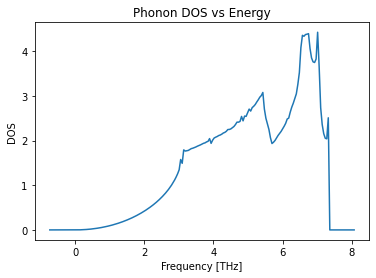

In [70]:
phon_job.plot_dos()